In [118]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from PIL import Image

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch import autograd
from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [119]:
main_qubits =  3
color_qubits = 3
q_depth = 3
num_ancilla = 1


In [120]:
batch_size = 1

cifar_data = torchvision.datasets.CIFAR10(root='./data/cifar10',train=True,download=True,transform=transforms.Compose(
                                                 [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))

cifar_loader = DataLoader(cifar_data,batch_size=batch_size,shuffle=True)

Files already downloaded and verified


In [121]:
new_loader = []
for i, (image, label) in enumerate(cifar_loader):
    # image = image.item()
    label = label.item()
    if label == 1:
        new_loader.append((image, label))
    if len(new_loader) == 100:
        break

In [122]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=list(range(main_qubits+color_qubits+num_ancilla+9)))
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(<Figure size 10200x1075 with 1 Axes>, <Axes: >)

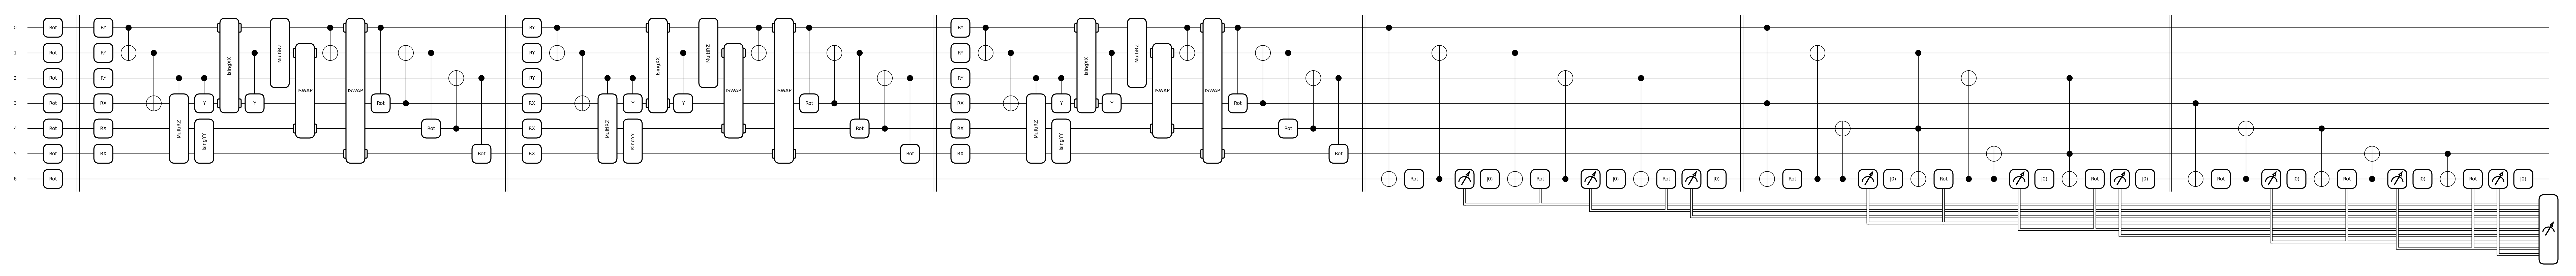

In [123]:
@qml.qnode(dev, diff_method = 'parameter-shift')
def quantum_circuit(noise, params):
    const = 19
    for wire in range(main_qubits+color_qubits+num_ancilla):
        qml.Rot(noise[3*wire], noise[3*wire+1], noise[3*wire+2], wires = wire)
    qml.Barrier()
    for layer in range(q_depth):
        for i in range(main_qubits+color_qubits):
            if i<3:
                qml.RY(params[const*layer + i], wires = i)
            else:
                qml.RX(params[const*layer+i], wires = i)
        qml.CNOT(wires = [0,1])
        qml.CNOT(wires = [1,3])
        qml.ctrl(qml.MultiRZ(params[const*layer+main_qubits+color_qubits], wires = [3,4,5]), control = 2, control_values = (1))
        qml.IsingYY(params[const*layer+main_qubits+color_qubits+1], wires = [4,5])
        qml.CY(wires = [2,3])
        qml.IsingXX(params[const*layer+main_qubits+color_qubits+2], wires = [0,3])
        qml.CY(wires = [1,3])
        qml.MultiRZ(params[const*layer+main_qubits+color_qubits+3], wires = [0,1,2])
        qml.ISWAP(wires = [1,4])
        qml.CNOT(wires = [0,1])
        qml.ISWAP(wires = [0,5])
        qml.CRot(params[const*layer+main_qubits+color_qubits+4],
                 params[const*layer+main_qubits+color_qubits+5],
                 params[const*layer+main_qubits+color_qubits+6], wires = [0,3])
        qml.CNOT(wires = [3,1])
        qml.CRot(params[const*layer+main_qubits+color_qubits+7],
                 params[const*layer+main_qubits+color_qubits+8],
                 params[const*layer+main_qubits+color_qubits+9], wires = [1,4])
        qml.CNOT(wires = [4,2])
        qml.CRot(params[const*layer+main_qubits+color_qubits+10],
                 params[const*layer+main_qubits+color_qubits+11],
                 params[const*layer+main_qubits+color_qubits+12], wires = [2,5])
        qml.Barrier()
    #measurement layer
    measurements = []
    for i in range(main_qubits):
        qml.CNOT(wires = [i,6])
        if i>0:
            qml.cond(measurements[i-1],qml.Rot)(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        else:
            qml.Rot(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        if i!=main_qubits-1:
            qml.CNOT(wires = [6,i+1])
        measurements.append(qml.measure(wires = 6, reset = True))
    qml.Barrier()
    for i in range(main_qubits):
        qml.Toffoli(wires = [i,i+3,6])
        if i>0:
            qml.cond(measurements[3+i-1],qml.Rot)(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        else:
            qml.Rot(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        if i!=main_qubits-1:
            qml.CNOT(wires = [6,i+1])
            qml.CNOT(wires = [6, i+4])
        measurements.append(qml.measure(wires = 6, reset = True))
    qml.Barrier()
    for i in range(main_qubits):
        qml.CNOT(wires = [main_qubits+i,6])
        if i>0:
            qml.cond(measurements[6+i-1],qml.Rot)(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        else:
            qml.Rot(params[const*q_depth+18+3*i], 
                    params[const*q_depth+18+3*i+1], 
                    params[const*q_depth+18+3*i+2], wires = 6)
        if i!=main_qubits-1:
            qml.CNOT(wires = [6,main_qubits+i+1])
        measurements.append(qml.measure(wires = 6, reset = True))

    return [qml.probs(op = measurements[i]) for i in range(len(measurements))]

noise = np.arange(21)
params = np.arange(q_depth*19 + 27)
qml.draw_mpl(quantum_circuit)(noise,params)


    
        

In [124]:
def quantum_process(noise, params):
    probs = quantum_circuit(noise, params)
    dummy_var = torch.eye(1)
    probs_red = torch.Tensor()
    probs_green = torch.Tensor()
    probs_blue = torch.Tensor()
    new_probs = torch.Tensor()
    
    probs_red.requires_grad = True
    probs_green.requires_grad = True
    probs_blue.requires_grad = True

    probs_red = torch.cat((probs_red, dummy_var))
    probs_blue = torch.cat((probs_blue, dummy_var))
    probs_green = torch.cat((probs_green, dummy_var))

    for index in range(9):
        if index < 3:
            probs_red = torch.kron(probs_red, probs[index])
            probs_green = torch.kron(probs_green, probs[index])
            probs_blue = torch.kron(probs_blue, probs[index])
        else:
            if (index % 3) == 0:
                probs_red = torch.kron(probs_red, probs[index])
            if (index % 3) == 1:
                probs_green = torch.kron(probs_green, probs[index])
            if (index % 3) == 2:
                probs_blue = torch.kron(probs_blue, probs[index])
    probs_red = torch.div(probs_red, torch.sum(probs_red))
    probs_green = torch.div(probs_green, torch.sum(probs_green))
    probs_blue = torch.div(probs_blue, torch.sum(probs_blue))

    probs_red = torch.div(probs_red, torch.max(probs_red))
    probs_green = torch.div(probs_green, torch.max(probs_green))
    probs_blue = torch.div(probs_blue, torch.max(probs_blue))
    
    new_probs = torch.cat((new_probs, probs_red, probs_blue, probs_green), dim = 0)
    return new_probs

quantum_process(torch.Tensor(noise),torch.Tensor(params))

        
        
    

tensor([[1.0000, 0.8825, 0.3648, 0.3219, 0.7405, 0.6534, 0.2701, 0.2384, 0.9285,
         0.8193, 0.3387, 0.2989, 0.6875, 0.6067, 0.2508, 0.2213, 0.8140, 0.7183,
         0.2969, 0.2620, 0.6027, 0.5319, 0.2198, 0.1940, 0.7557, 0.6669, 0.2757,
         0.2433, 0.5596, 0.4938, 0.2041, 0.1801],
        [1.0000, 0.9010, 0.3405, 0.3068, 0.7405, 0.6672, 0.2521, 0.2271, 0.9285,
         0.8365, 0.3161, 0.2848, 0.6875, 0.6194, 0.2341, 0.2109, 0.8140, 0.7334,
         0.2771, 0.2497, 0.6027, 0.5430, 0.2052, 0.1849, 0.7557, 0.6809, 0.2573,
         0.2318, 0.5596, 0.5042, 0.1905, 0.1717],
        [1.0000, 0.8411, 0.6117, 0.5145, 0.7405, 0.6228, 0.4530, 0.3810, 0.9285,
         0.7809, 0.5679, 0.4777, 0.6875, 0.5782, 0.4205, 0.3537, 0.8140, 0.6846,
         0.4979, 0.4188, 0.6027, 0.5069, 0.3687, 0.3101, 0.7557, 0.6356, 0.4623,
         0.3888, 0.5596, 0.4707, 0.3423, 0.2879]], dtype=torch.float64,
       grad_fn=<CatBackward0>)

In [125]:
class QuantumGenerator(nn.Module):
    def __init__(self, q_delta = 0.8, num_generators = 16):
        super().__init__()
        self.num_generators = num_generators
        self.q_depth = q_depth
        self.q_params = nn.ParameterList(
        [
            q_delta * torch.rand((self.q_depth * 19 + 27))
            for _ in range(self.num_generators)
        ])
        self.expand = nn.Sequential(
            nn.ConvTranspose2d(96, 32, 12, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 12, 8, 1),
            nn.BatchNorm2d(12),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(12, 3, 8, 1),
            nn.Sigmoid()

        )
    def forward(self, x):
        patch_size = 32
        images = torch.Tensor(3*x.size(0), 0).to(device)
        for params in self.q_params:
            patches = torch.Tensor(0, patch_size)
            for elem in x:
                quantum_probs = quantum_process(elem, params).float()
                patches = torch.cat((patches, quantum_probs))
            images = torch.cat((images, patches), dim = 1)
        images = images.view(x.size(0),96,4,4)
        images = self.expand(images)
        # print(images.shape)

        return images
            

In [126]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()

        )

    def forward(self, x):
        return self.model(x)

In [131]:
lrG = 0.18 # Learning rate for the generator
lrD = 0.0002 # Learning rate for the discriminator
num_iter = 200  # Number of training iterations

In [132]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, 21, device=device) * math.pi
# print(fixed_noise)

# Iteration counter

# Collect images for plotting later
results = []
for epoch in range(2):
    for i, (data, _) in enumerate(new_loader):

        # Data for training the discriminator
        # print(data.shape)
        # data = data.reshape(-1, 28*28)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(1, 21, device=device) * math.pi 
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

    
        # Show loss values
        
        print(f'Epoch: {epoch+1}, Iteration: {i+1}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            # print(generator(fixed_noise)..shape())
            # print(test_images.sh/ape)

        # Save images every 50 iterations
       
        print('saving the output')
        torchvision.utils.save_image(real_data,'color_outputs/real_data/real_samples.png',normalize=True)
        fake = generator(fixed_noise)
        torchvision.utils.save_image(fake.detach(),'color_outputs/fake_data/fake_samples_epoch_%03d.png' % (epoch),normalize=True)



Epoch: 1, Iteration: 1, Discriminator Loss: 1.912, Generator Loss: 0.893
saving the output
Epoch: 1, Iteration: 2, Discriminator Loss: 1.844, Generator Loss: 0.694
saving the output
Epoch: 1, Iteration: 3, Discriminator Loss: 1.631, Generator Loss: 0.777
saving the output
Epoch: 1, Iteration: 4, Discriminator Loss: 1.439, Generator Loss: 0.779
saving the output
Epoch: 1, Iteration: 5, Discriminator Loss: 1.605, Generator Loss: 0.680
saving the output
Epoch: 1, Iteration: 6, Discriminator Loss: 1.758, Generator Loss: 0.614
saving the output
Epoch: 1, Iteration: 7, Discriminator Loss: 2.042, Generator Loss: 0.562
saving the output
Epoch: 1, Iteration: 8, Discriminator Loss: 1.793, Generator Loss: 0.631
saving the output
Epoch: 1, Iteration: 9, Discriminator Loss: 1.558, Generator Loss: 0.622
saving the output
Epoch: 1, Iteration: 10, Discriminator Loss: 2.066, Generator Loss: 0.657
saving the output
Epoch: 1, Iteration: 11, Discriminator Loss: 1.948, Generator Loss: 0.615
saving the outp